In [1]:
import numpy as np
import pandas as pd 
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16

2024-04-07 19:22:52.303721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 19:22:52.303832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 19:22:52.601986: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_dim = 256
num_classes = 5

class NPYDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images_path, masks_path, batch_size=32, dim=(256, 256), n_channels=3, n_classes=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.images_path = images_path
        self.masks_path = masks_path
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.image_ids = [os.path.splitext(file)[0] for file in os.listdir(images_path)]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        image_ids_temp = [self.image_ids[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(image_ids_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_ids_temp):
        'Generates data containing batch_size samples' 
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_classes))

        # Generate data
        for i, ID in enumerate(image_ids_temp):
            # Store sample
            image_path = os.path.join(self.images_path, ID + '.jpg')
            image = cv2.imread(image_path)
            image = cv2.resize(image, self.dim)
            image = image / 255.0  # Normalize to [0, 1]
            X[i,] = image

            # Store class
            mask_path = os.path.join(self.masks_path, ID + '.npy')
            mask = np.load(mask_path)
            y[i,] = mask

        return X, y


# Set up the paths for the training and validation images and masks
train_images_path = '/kaggle/input/cv-road-marking/augmented_dataset/images/train' # Replace with your path to training images
train_masks_path = '/kaggle/input/cv-road-marking/augmented_dataset/masks/train' # Replace with your path to training masks

val_images_path = '/kaggle/input/cv-road-marking/augmented_dataset/images/valid' # Replace with your path to validation images
val_masks_path = '/kaggle/input/cv-road-marking/augmented_dataset/masks/valid' # Replace with your path to validation masks

test_images_path = '/kaggle/input/cv-road-marking/augmented_dataset/images/test' # Replace with your path to training images
test_masks_path = '/kaggle/input/cv-road-marking/augmented_dataset/masks/test'
# Create the data generators
train_generator = NPYDataGenerator(train_images_path, train_masks_path, batch_size=32, dim=(img_dim, img_dim), n_channels=3, n_classes=num_classes, shuffle=True)
val_generator = NPYDataGenerator(val_images_path, val_masks_path, batch_size=32, dim=(img_dim, img_dim), n_channels=3, n_classes=num_classes, shuffle=False)
test_generator = NPYDataGenerator(test_images_path, test_masks_path, batch_size=32, dim=(img_dim, img_dim), n_channels=3, n_classes=num_classes, shuffle=False)

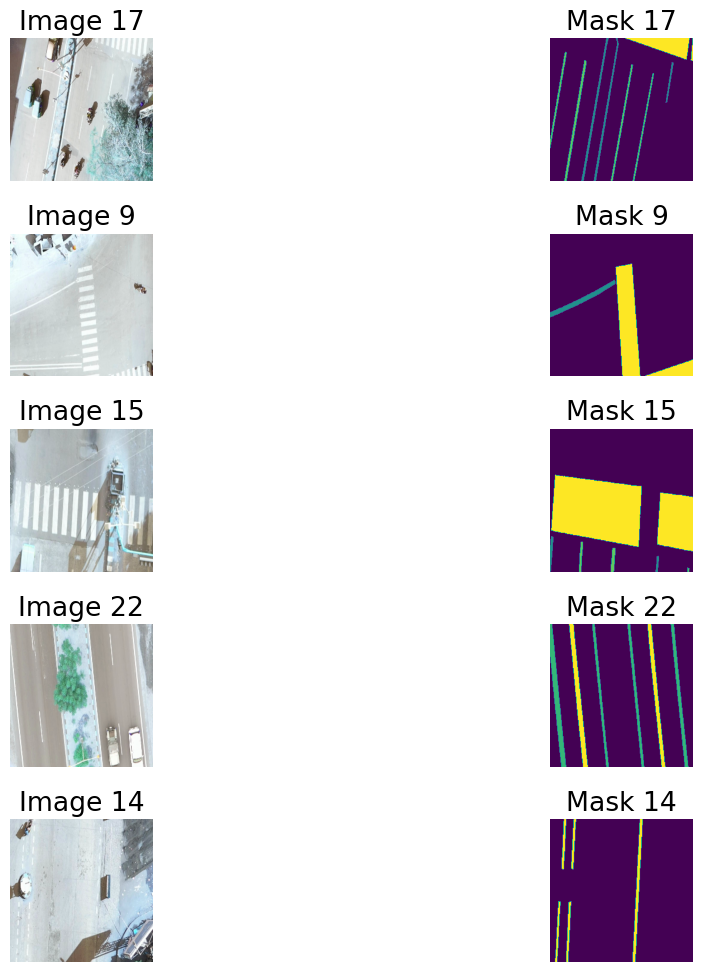

In [3]:
import matplotlib.pyplot as plt

def visualize_batch(generator, num_images=5):
    # Generate a batch of data
    X, y = generator[0]  # Get the first batch from the generator
    
    # Select num_images random indices from the batch
    indices = np.random.choice(range(X.shape[0]), size=num_images, replace=False)
    
    # Plot the images and masks
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        # Plot original image
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(X[idx])
        plt.title(f'Image {idx}')
        plt.axis('off')

        # Plot mask (assuming mask is a one-hot encoded array)
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(np.argmax(y[idx], axis=-1), cmap='viridis')  # Displaying mask as an image
        plt.title(f'Mask {idx}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training images and masks
visualize_batch(train_generator, num_images=5)


In [4]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape,num_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [5]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
loss='categorical_crossentropy', # Use 'categorical_crossentropy' for multi-class
metrics=['accuracy']) # It's better to start with 'accuracy'
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 7,772,005 (29.65 MB)

 Trainable params: 7,766,117 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [16]:
import tensorflow as tf

@register_keras_serializable
def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    
    return iou


# Use IoU in your model's metrics
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[iou_coef, 'accuracy'])

checkpoint = ModelCheckpoint(
    'unet_road_marking.keras', 
    monitor='val_iou_coef',
    verbose=1, 
    save_best_only=True, 
    mode='max'
)
# Early stopping based on IoU
earlystop = EarlyStopping(monitor='val_iou_coef',  # Make sure to use the correct name of your IoU metric here
                          patience=10, 
                          verbose=1, 
                          mode='max',  # We want to maximize IoU
                          restore_best_weights=True)

# Now you can fit your model with these callbacks


In [8]:
# Next, create instances of the NPYDataGenerator for training and validation data
train_data_generator = NPYDataGenerator(
    images_path='/kaggle/input/cv-road-marking/augmented_dataset/images/train',  # Replace with your train images .npy path
    masks_path='/kaggle/input/cv-road-marking/augmented_dataset/masks/train',    # Replace with your train masks .npy path
    batch_size=32,
    dim=(img_dim, img_dim),
    n_channels=3,
    n_classes=num_classes,  # Replace with your actual number of classes
    shuffle=True
)

val_data_generator = NPYDataGenerator(
    images_path='/kaggle/input/cv-road-marking/augmented_dataset/images/valid',  # Replace with your validation images .npy path
    masks_path='/kaggle/input/cv-road-marking/augmented_dataset/masks/valid',    # Replace with your validation masks .npy path
    batch_size=32,
    dim=(img_dim, img_dim),
    n_channels=3,
    n_classes=num_classes,  # Replace with your actual number of classes
    shuffle=True
)

In [9]:
history = model.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=70,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/70


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-07 05:29:35.583468: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,256,256]{3,2,1,0}, f32[32,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-07 05:29:36.045401: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.462164382s
Trying algorithm eng0{} for conv (f32[32,3

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7245 - iou_coef: 0.2763 - loss: 1.0063
Epoch 1: val_iou_coef improved from -inf to 0.13176, saving model to unet_road_marking.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.7271 - iou_coef: 0.2787 - loss: 1.0004 - val_accuracy: 0.2983 - val_iou_coef: 0.1318 - val_loss: 2.8043
Epoch 2/70
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.9239 - iou_coef: 0.6048 - loss: 0.3773
Epoch 2: val_iou_coef improved from 0.13176 to 0.43625, saving model to unet_road_marking.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 670ms/step - accuracy: 0.9240 - iou_coef: 0.6054 - loss: 0.3767 - val_accuracy: 0.8406 - val_iou_coef: 0.4363 - val_loss: 0.7062
Epoch 3/70
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9328 - iou_coef: 0.7099 - loss: 0.2789
Epoch 3: val_iou_coef improved from 0.43625 to 0.61894, saving model to unet_road_marking.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 672ms/step - accuracy: 0.9329 - iou_coef: 0.7102 - loss: 0.2787 -

In [2]:
@register_keras_serializable
def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    
    return iou


In [10]:
# Saving the model
model.save('unet_road_marking.keras')


In [11]:
import seaborn as sns
sns.set_style('dark')

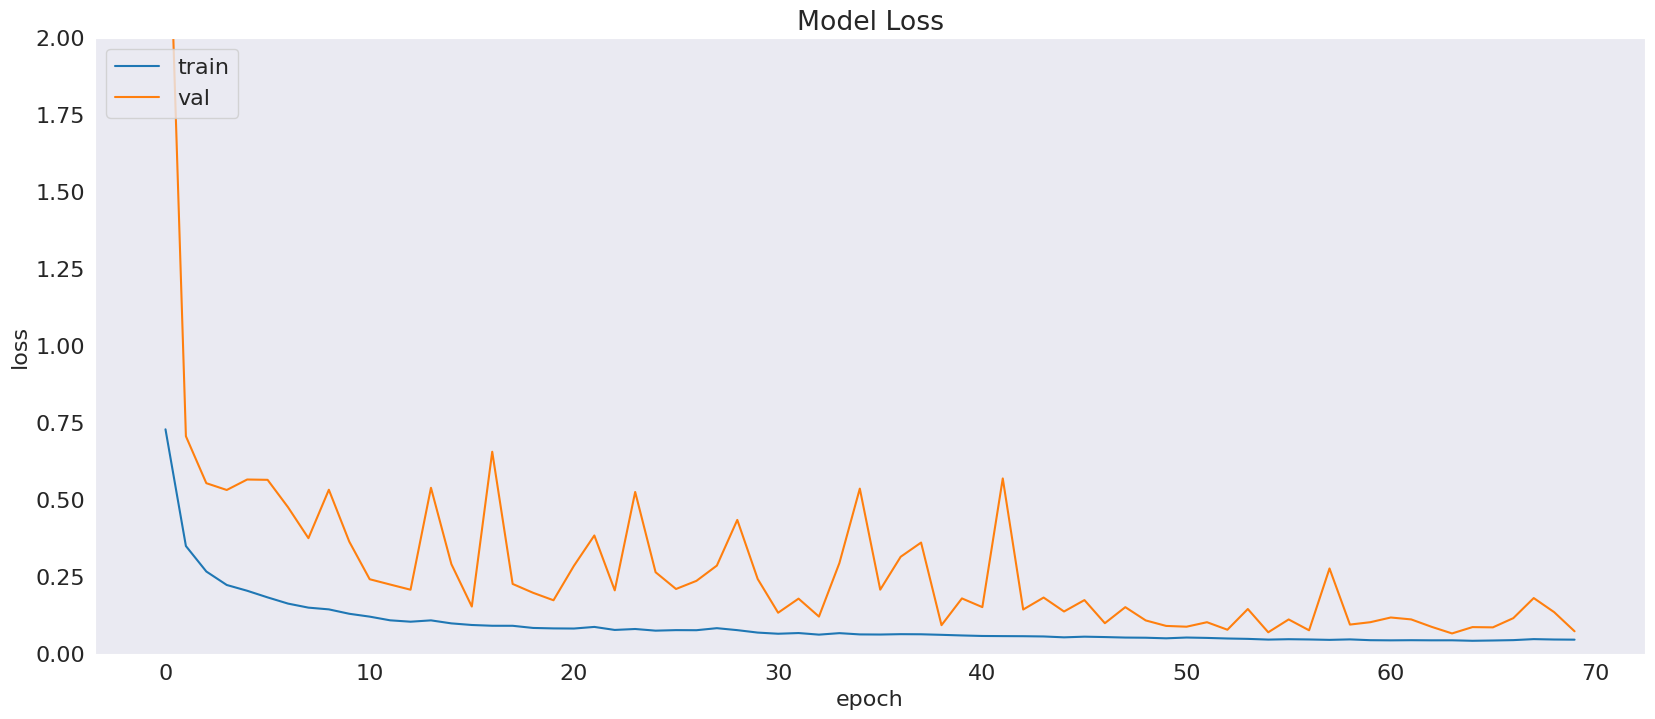

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


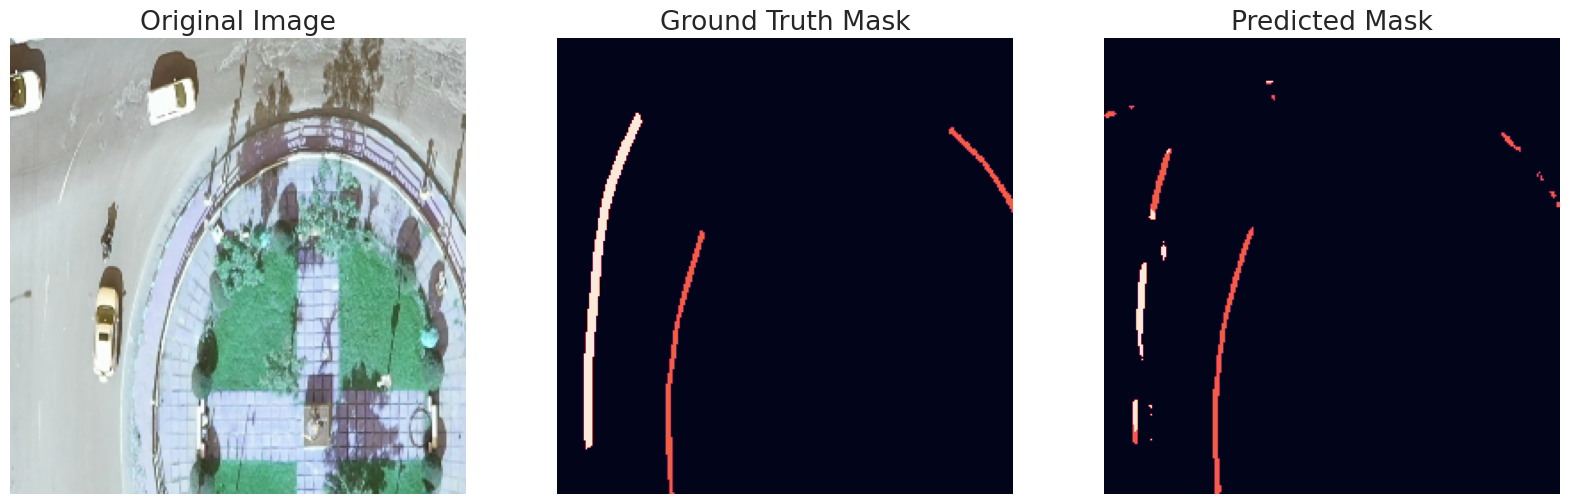

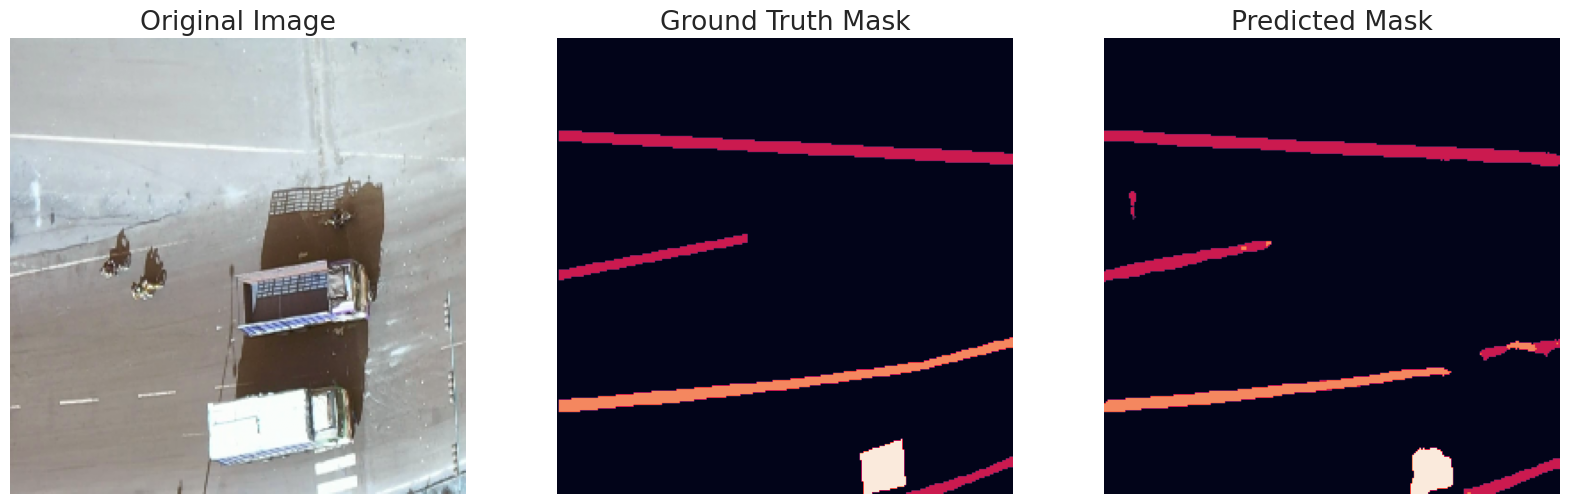

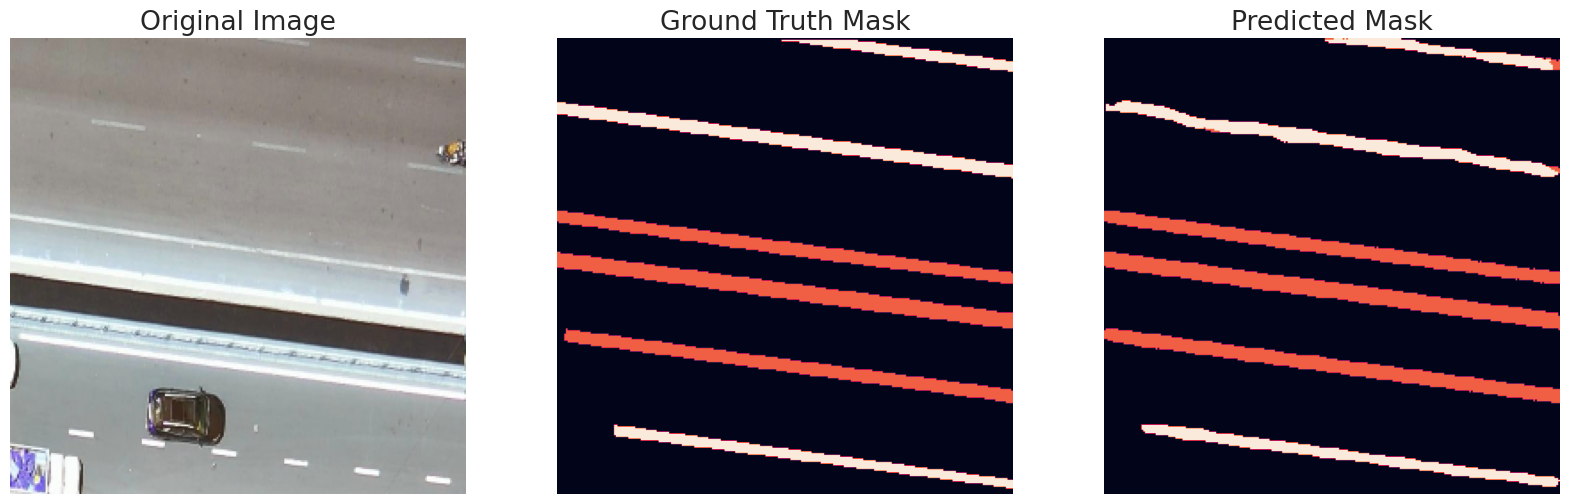

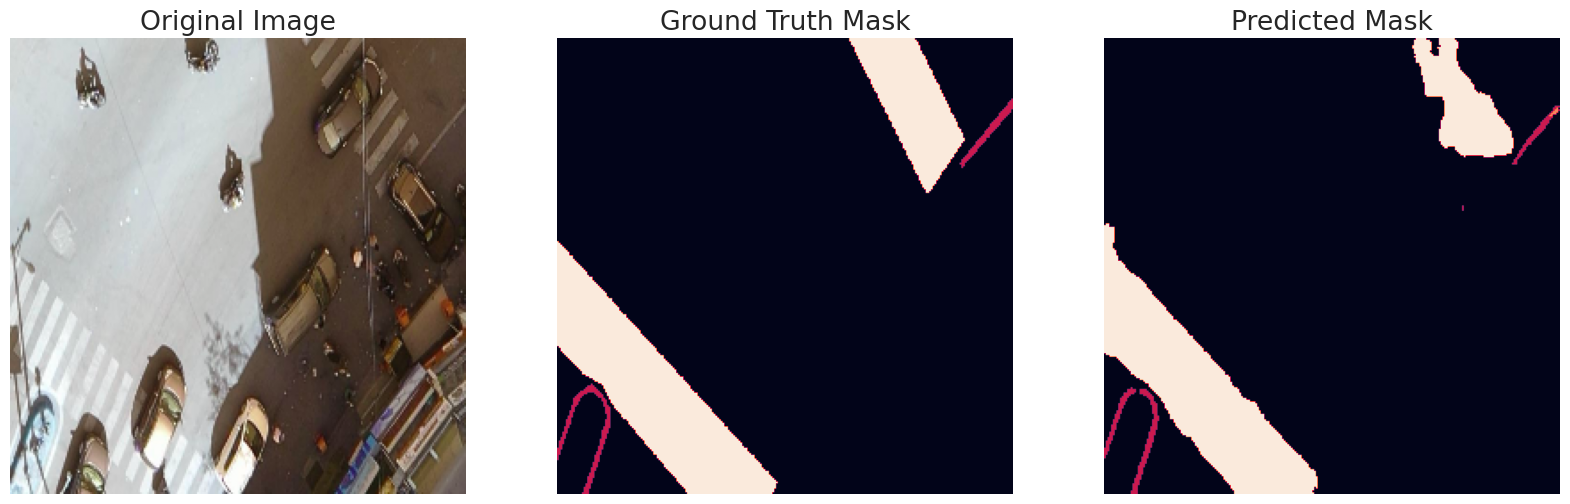

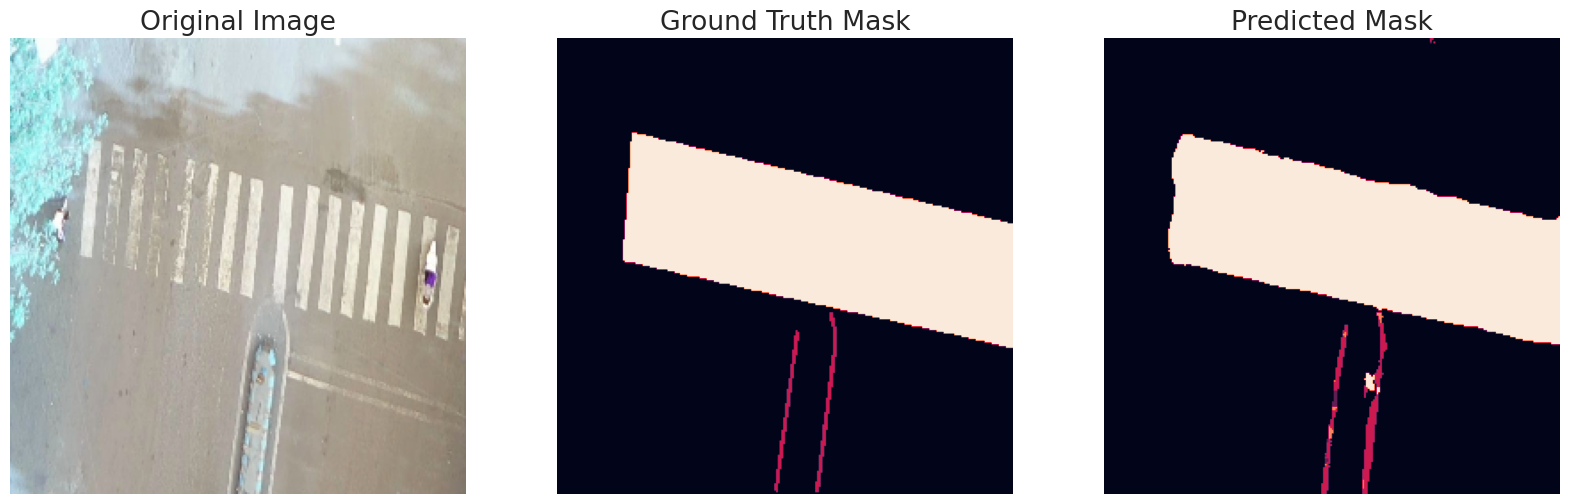

In [17]:
# Initialize the data generator for your test data
test_images_path = '/kaggle/input/cv-road-marking/augmented_dataset/images/test'  # replace with your test images path
test_masks_path = '/kaggle/input/cv-road-marking/augmented_dataset/masks/test'  # replace with your test masks path

test_generator = NPYDataGenerator(
    images_path=test_images_path,
    masks_path=test_masks_path,
    batch_size=5,  # Set batch size to 1 for demonstration purposes
    dim=(256, 256),
    n_channels=3,
    n_classes=5,  # Set this to your actual number of classes
    shuffle=False
)

import tensorflow as tf

# Load the saved model
saved_model_path = '/kaggle/working/unet_road_marking.keras'
model = tf.keras.models.load_model(saved_model_path, custom_objects={'iou_coef': iou_coef})

# Make predictions using the loaded model on new data
# (Assuming input_data is preprocessed input data)
# predictions = model.predict(input_data)

# Load one batch of data
test_images, test_masks = test_generator.__getitem__(0)

predicted_masks = model.predict(test_images)

# Convert predictions to class labels
predicted_masks = np.argmax(predicted_masks, axis=-1)
# print(test_images.shape)
# Visualization
num_images_to_show = min(5, len(test_images))
# test_images = test_images[0]
# test_masks = test_masks[0]
for i in range(num_images_to_show):
#     print("x")
    plt.figure(figsize=(20, 8))
    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i])
    plt.title('Original Image')
    plt.axis('off')

    # Display the ground truth mask
    plt.subplot(1, 3, 2)
    ground_truth = np.argmax(test_masks[i], axis=-1)  # Assuming the masks are one-hot encoded
    plt.imshow(ground_truth, )
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[i],)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

In [25]:
# model.save('unet_multiclass_iou_good.keras')

In [3]:
# import shutil
# saved_model_path = '/kaggle/input/road_marking_detection/keras/road_marking_detection_iou_92/1/unet_road_marking.keras'
# # Specify a writable directory
# target_directory = '/kaggle/working/'

# # Copy the model file to the writable directory
# shutil.copy(saved_model_path, target_directory)

'/kaggle/working/unet_road_marking.keras'

In [5]:
model = tf.keras.models.load_model('/kaggle/working/unet_road_marking.keras', custom_objects={'iou_coef': iou_coef})

In [100]:
# print(test_images.shape)
# predicted_masks = model.predict(test_images)
# print(predicted_masks.shape)
# predicted_masks[0].shape


(5, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(5, 256, 256, 5)


(256, 256, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


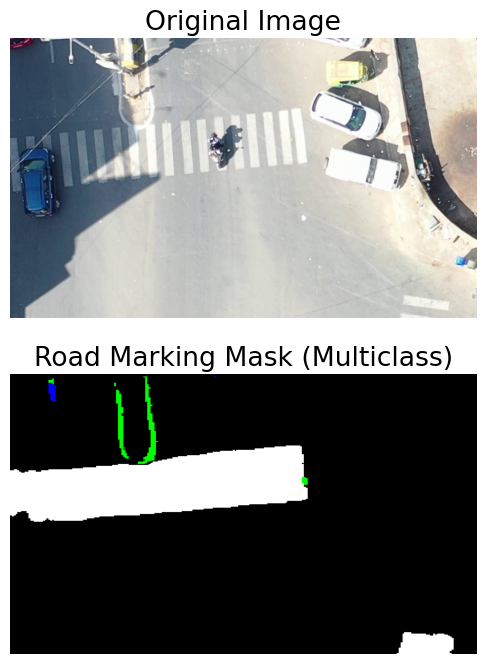

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mask_to_color_image(predicted_mask, class_colors):
    color_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_label, color in enumerate(class_colors):
        color_mask[predicted_mask == class_label] = color

    return color_mask

def resize_image(image, target_size):
    resized_image = cv2.resize(image, target_size[::-1], interpolation=cv2.INTER_NEAREST)
    return resized_image

# Define the class colors corresponding to your model's output classes
class_colors = [
    (0, 0, 0),# black Background
    (255, 0, 0), # red traffic sign
    (0, 255, 0), # green Divider
    (0, 0, 255), # blue lane marking
    (255, 255, 255),# white Zebra- crossing
]

# Path to your original image
image_path = '/kaggle/input/cv-road-marking/augmented_dataset/images/valid/2_32.jpg'  # Update with your image path

# Load and resize the original image to 256x256
original_image = cv2.imread(image_path)
resized_image = cv2.resize(original_image, (256, 256))

from PIL import Image
import io

def resize_image_pillow(image_path, target_size=(256, 256), quality=100):
    # Open the image using Pillow
    image = Image.open(image_path)

    # Resize the image while preserving aspect ratio
    image.thumbnail(target_size, Image.ANTIALIAS)

    # Convert the image to RGB (if not already in RGB mode)
    image = image.convert('RGB')

    # Save the resized image to a BytesIO object to control JPEG quality
    output = io.BytesIO()
    image.save(output, format='JPEG', quality=quality)

    # Read the resized image back from the BytesIO object
    resized_image = Image.open(output)
    resized_image = np.array(resized_image)  # Convert PIL Image to NumPy array

    return resized_image

# Example usage:
# image_path = '/path/to/your/image.jpg'
# resized_image = resize_image_pillow(image_path, target_size=(256, 256), quality=90)

# Display the resized image using matplotlib
# plt.imshow(resized_image)
# plt.title('Resized Image (Pillow)')
# plt.axis('off')
# plt.show()

image_size = (original_image.shape[0], original_image.shape[1])

# Convert the resized image to a numpy array and normalize it
input_image = resized_image.astype(np.float32) / 255.0

# Reshape the input image to match model's input shape (e.g., batch size of 1)
input_image = np.expand_dims(input_image, axis=0)

# Use the model to predict masks for the input image
predicted_masks = model.predict(input_image)

# Assuming predicted_masks[0] is the predicted mask for the first image in the batch
predicted_labels = np.argmax(predicted_masks[0], axis=-1)

# Create the color mask from predicted labels
color_mask = mask_to_color_image(predicted_labels, class_colors)

# Resize the color mask to the desired size (e.g., 960x576)
target_size = image_size
resized_mask = resize_image(color_mask, target_size)

# Plot the original image and resized color mask side by side
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(resized_mask)
plt.title('Road Marking Mask (Multiclass)')
plt.axis('off')

plt.show()


/tmp/ipykernel_34/122328204.py:46: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)  # Convert to integers


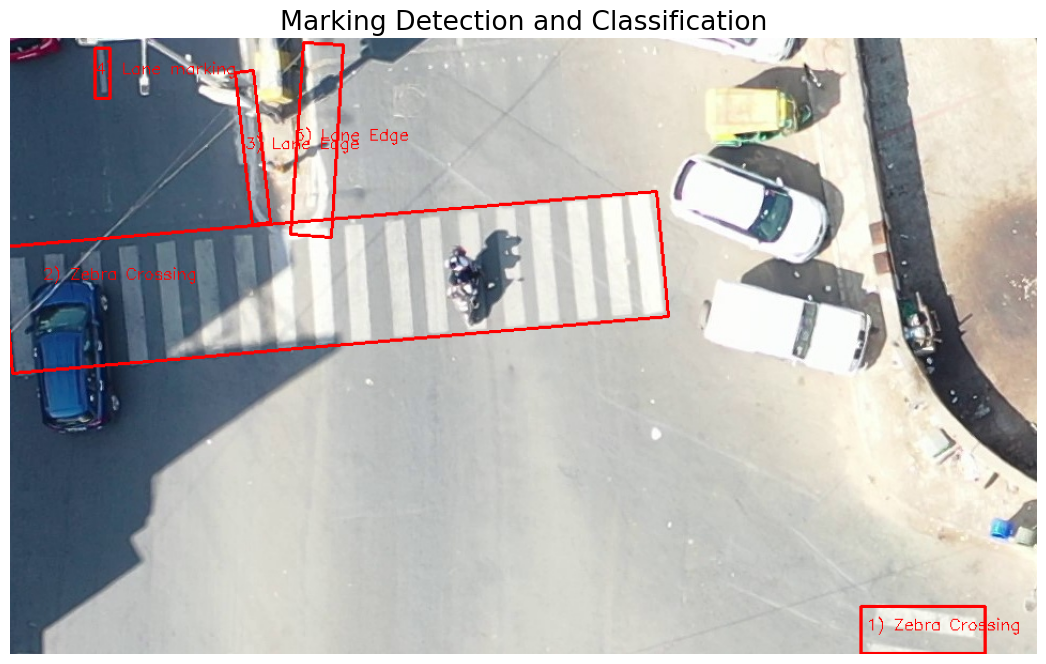

Mark 1:'Zebra Crossing'  Width = 116.00px, Height = 44.00px,
Mark 2:'Zebra Crossing'  Width = 614.21px, Height = 117.52px,
Mark 3:'Lane Edge'  Width = 17.12px, Height = 142.90px,
Mark 4:'Lane marking'  Width = 14.00px, Height = 47.00px,
Mark 5:'Lane Edge'  Width = 179.40px, Height = 37.05px,


In [42]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

@register_keras_serializable
def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    
    return iou


def find_pixel_length_width_color(mask_image, original_image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    # Find contours in the mask image
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize lists to store the dimensions, colors, and assigned labels of contours
    dimensions = []
    contour_colors = []
    contour_labels = []

    # Define reference colors for labeling (Lane marking, Lane Edge, Zebra Crossing, Traffic sign) in BGR format
    reference_colors = {
        "Lane marking": (0, 0, 255),
        "Lane Edge": (0, 255, 0),
        "Zebra Crossing": (255, 255, 255),
        "Traffic sign": (255, 0, 0)
    }

    for contour in contours:
        # Minimum area rectangle
        area = cv2.contourArea(contour)

        # Check if contour area is above the minimum threshold
        if area < 300:
            continue 
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)  # Convert to box points
        box = np.int0(box)  # Convert to integers

        # Calculate dimensions
        width = np.linalg.norm(box[0] - box[1])
        height = np.linalg.norm(box[1] - box[2])
        dimensions.append((width, height))

        # Extract the mean color of the contour from the original image
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        mean_color = cv2.mean(mask_image, mask=mask)[:3]
        contour_colors.append(mean_color)

        # Compare contour color with reference colors and assign label
        min_distance = float('inf')
        assigned_label = "Unknown"

        for label, color in reference_colors.items():
            distance = np.linalg.norm(np.array(mean_color) - np.array(color))
            if distance < min_distance:
                min_distance = distance
                assigned_label = label

        contour_labels.append(assigned_label)

        # Draw the minimum area rectangle
        cv2.drawContours(original_image, [box], 0, (0, 0, 255), 2)

        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)

        # Place text label inside the bounding box
        cv2.putText(original_image, f"{len(contour_labels)}) {assigned_label}", (x + int(w * 0.05), y + int(h * 0.5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # Plot the image with bounding boxes and labels
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Marking Detection and Classification')
    plt.axis('off')
    plt.show()
    
    output_image_path = '/kaggle/working/annotated_image.jpg'
    plt.savefig(output_image_path, bbox_inches='tight')
    plt.close()
    
    return dimensions, contour_colors, contour_labels

# Example usage
# Load your mask image (e.g., 'resized_mask')
mask_image = resized_mask

# Create a copy of the mask image for drawing purposes
# original_image = mask_image.copy()

# Call the function to analyze contours, compare colors, and assign labels
dimensions, contour_colors, contour_labels = find_pixel_length_width_color(mask_image, original_image)

# Display the dimensions, colors, and assigned labels of detected contours
for i, ((width, height), color, label) in enumerate(zip(dimensions, contour_colors, contour_labels), start=1):
    print(f"Mark {i}:'{label}'  Width = {width:.2f}px, Height = {height:.2f}px,")
